In [1]:
import random
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import esda
import libpysal.weights as weights
from esda.moran import Moran
from esda.moran import Moran_Local
from shapely.geometry import Point, MultiPoint, LineString, Polygon, shape
import json
import pylab
import networkx as nx
import libpysal
import numpy as np
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import f1_score
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.birch import birch
from pyclustering.cluster.cure import cure
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.optics import optics
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [2]:
def permutation(lst):
    if len(lst) == 0:
        return []

    if len(lst) == 1:
        return [lst]

    l = []
    for i in range(len(lst)):
        m = lst[i]
        remLst = lst[:i] + lst[i+1:]
        for p in permutation(remLst):
            l.append([m] + p)       
    return l

In [3]:
def get_f1_score(df, permut):
    def match_clus(x, permut):
        if x == 0:
            return int(permut[0])
        elif x == 1:
            return int(permut[1])
        elif x == 2:
            return int(permut[2])
        elif x == 3:
            return int(permut[3])
        elif x == 4:
            return int(permut[4])
        elif x == 5:
            return int(permut[5])
        elif x == 6:
            return int(permut[6])
        else:
            return x

    df["group_match"] = df["group"].apply(lambda x: match_clus(x, permut))
    return df, f1_score(df.group_match.values, df.clus_group_gt.values, average='macro')

In [4]:
def get_max_f1_score(df):
    max_f1 = 0
    max_p = []
    for p in permutation([1,2,3,4,5,6,7]):
        df, f1 = get_f1_score(df, p)
        if max_f1 < f1:
            max_f1 = f1
            max_p = p
    print("f1_score ", max_f1, max_p)

In [5]:
def cal_joint_statistic(synthetic_data_sticc, w_voronoi):
    matched_connects = 0
    all_neighbors_connects = 0
    for obj_id, neighbors in w_voronoi.neighbors.items():
        obj_clus = synthetic_data_sticc.iat[obj_id, -1]
        for nei in neighbors:
            nei_clus = synthetic_data_sticc.iat[nei, -1]
            all_neighbors_connects += 1
            if obj_clus == nei_clus:
                matched_connects += 1
    return matched_connects / all_neighbors_connects

# Ground Truth

In [6]:
synthetic_data = gpd.read_file('data/sticc_points.shp')
synthetic_data = synthetic_data.drop(["CID", "geometry"], axis=1)
synthetic_data["x"] = synthetic_data["x"] + 9965410
synthetic_data["y"] = synthetic_data["y"] - 5308400
synthetic_data["geometry"] = gpd.points_from_xy(x=synthetic_data.x, y=synthetic_data.y)
synthetic_data.head(1)

,clus_group,x,y,geometry
0,1,660.0,15060.0,POINT (660.000 15060.000)


In [7]:
def get_gt(x):
    if x == 8:
        return 3
    elif x == 4:
        return 1
    elif x == 9:
        return 4
    elif x == 10:
        return 2
    else:
        return x
    
synthetic_data["clus_group_gt"] = synthetic_data["clus_group"].apply(lambda x: get_gt(x))
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt
0,1,660.0,15060.0,POINT (660.000 15060.000),1


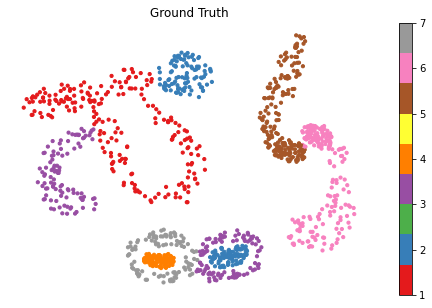

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
synthetic_data.plot(ax=ax, column="clus_group_gt", cmap="Set1", markersize=markersize, legend=True)
ax.set_axis_off()
ax.title.set_text('Ground Truth')

In [9]:
np.random.seed(1234)
def get_attr1(x):
    if x == 1:
        return np.random.normal(4, 1)
    elif x == 2:
        return np.random.normal(5, 1)
    elif x == 3:
        return np.random.normal(6, 1)
    elif x == 4:
        return np.random.normal(1, 1)
    elif x == 5:
        return np.random.normal(3, 1)
    elif x == 6:
        return np.random.normal(7, 1)
    elif x == 7:
        return np.random.normal(2, 1)
    
synthetic_data["attr1"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr1(x))

In [10]:
def get_attr2(x):
    if x == 1:
        return np.random.normal(1, 3)
    elif x == 2:
        return np.random.normal(7, 3)
    elif x == 3:
        return np.random.normal(2, 3)
    elif x == 4:
        return np.random.normal(3, 3)
    elif x == 5:
        return np.random.normal(6, 3)
    elif x == 6:
        return np.random.normal(4, 3)
    elif x == 7:
        return np.random.normal(5, 3)
    
synthetic_data["attr2"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr2(x))

In [11]:
def get_attr3(x):
    if x == 1:
        return np.random.normal(80, 20)
    elif x == 2:
        return np.random.normal(30, 20)
    elif x == 3:
        return np.random.normal(20, 20)
    elif x == 4:
        return np.random.normal(100, 20)
    elif x == 5:
        return np.random.normal(60, 20)
    elif x == 6:
        return np.random.normal(70, 20)
    elif x == 7:
        return np.random.normal(40, 20)
    
synthetic_data["attr3"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr3(x))

In [12]:
def get_attr4(x):
    if x == 1:
        return np.random.normal(1000, 350)
    elif x == 2:
        return np.random.normal(900, 350)
    elif x == 3:
        return np.random.normal(600, 350)
    elif x == 4:
        return np.random.normal(700, 350)
    elif x == 5:
        return np.random.normal(800, 350)
    elif x == 6:
        return np.random.normal(400, 350)
    elif x == 7:
        return np.random.normal(500, 350)
    
synthetic_data["attr4"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr4(x))

In [13]:
def get_attr5(x):
    if x == 1:
        return np.random.normal(999, 3)
    elif x == 2:
        return np.random.normal(992, 3)
    elif x == 3:
        return np.random.normal(1005, 3)
    elif x == 4:
        return np.random.normal(1003, 3)
    elif x == 5:
        return np.random.normal(999, 3)
    elif x == 6:
        return np.random.normal(998, 3)
    elif x == 7:
        return np.random.normal(1008, 3)
    
synthetic_data["attr5"] = synthetic_data["clus_group_gt"].apply(lambda x: get_attr5(x))

In [14]:
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216


In [15]:
pts_all = []
for pt in synthetic_data.iterrows():
    pts_all.append((pt[1].x, pt[1].y))
kd = libpysal.cg.KDTree(np.array(pts_all))
wnn = libpysal.weights.KNN(kd, 3)

/home/kangyuhao/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 12 disconnected components.
  warnings.warn(message)


In [16]:
nearest_pt = pd.DataFrame().from_dict(wnn.neighbors, orient="index")
for i in range(nearest_pt.shape[1]):
    nearest_pt = nearest_pt.rename({i:f"n_pt_{i}"}, axis=1)
nearest_pt.head(1)

,n_pt_0,n_pt_1,n_pt_2
0,41,78,45


In [17]:
synthetic_data = synthetic_data.join(nearest_pt)
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [18]:
synthetic_data[["attr1", "attr2", 
                "attr3", 
                "attr4", "attr5", 
                "n_pt_0", "n_pt_1", "n_pt_2"
               ]].to_csv(r'synthetic_data.txt', header=None, index=True, sep=',')

In [19]:
synthetic_data_input = pd.read_table(r'synthetic_data.txt', sep=',', names=["id", "attr1", "attr2", 
                "attr3", 
                "attr4", "attr5", 
                "n_pt_0", "n_pt_1", "n_pt_2"
               ])
synthetic_data_input = synthetic_data_input.set_index("id")
synthetic_data_input.head(1)

,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
id,,,,,,,,
0,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [20]:
synthetic_data[["attr1", "attr2", 
                "attr3", "attr4", "attr5"]] = synthetic_data_input[["attr1", "attr2", 
                "attr3", "attr4", "attr5"]]
synthetic_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [21]:
w_voronoi = weights.Voronoi.from_dataframe(synthetic_data)

# STICC

In [22]:
def get_sticc_result(ground_truth, save_fig=False):
    sticc_group = pd.read_table('result_synthetic_data.txt', names=["group"])
    synthetic_data_sticc = ground_truth.join(sticc_group)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    markersize = 10
    synthetic_data_sticc.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)
    
    ax.set_axis_off()
    ax.title.set_text('STICC')
    if save_fig:
        fig.savefig('paper/exp1_result/sticc.jpg', dpi=300, bbox_inches='tight')

    print("ARI", adjusted_rand_score(synthetic_data_sticc.group, synthetic_data_sticc.clus_group_gt))
    
    sp_contiguity = cal_joint_statistic(synthetic_data_sticc, w_voronoi)
    print("Spatial contiguity: ", sp_contiguity)
    
    get_max_f1_score(synthetic_data_sticc)
    
    return synthetic_data_sticc

In [29]:
!rm -rf result_synthetic_data.txt
!python STICC_main.py --fname=synthetic_data.txt --oname=result_synthetic_data.txt --attr_idx_start=1 \
--attr_idx_end=5 --spatial_idx_start=6 --spatial_idx_end=8 \
--spatial_radius=3 --number_of_clusters 7 --lambda_parameter 0.01 --beta 3 --maxIters 20 

lam_sparse 0.01
switch_penalty 3.0
num_cluster 7
num stacked 3
completed getting the data
5 (1213, 5) (1213, 3)



ITERATION ### 0
OPTIMIZATION for Cluster # 0 DONE!!!
OPTIMIZATION for Cluster # 1 DONE!!!
OPTIMIZATION for Cluster # 2 DONE!!!
OPTIMIZATION for Cluster # 3 DONE!!!
OPTIMIZATION for Cluster # 4 DONE!!!
OPTIMIZATION for Cluster # 5 DONE!!!
OPTIMIZATION for Cluster # 6 DONE!!!
length of the cluster  0 ------> 142
length of the cluster  1 ------> 192
length of the cluster  2 ------> 210
length of the cluster  3 ------> 199
length of the cluster  4 ------> 181
length of the cluster  5 ------> 145
length of the cluster  6 ------> 144
UPDATED THE OLD COVARIANCE
beginning the smoothening ALGORITHM
length of cluster # 0 --------> 185
length of cluster # 1 --------> 206
length of cluster # 2 --------> 154
length of cluster # 3 --------> 197
length of cluster # 4 --------> 184
length of cluster # 5 --------> 173
length of cluster # 6 --------> 114







ITERATION ### 1
OPTIMIZATION 

ARI 0.9518207474528948
Spatial contiguity:  0.8950847944811727
f1_score  0.9816422632076656 [6, 4, 5, 7, 3, 1, 2]


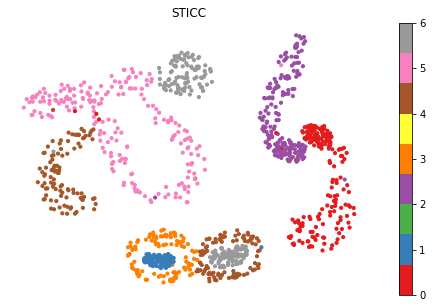

In [30]:
synthetic_data_sticc = get_sticc_result(synthetic_data)

# Pyclustering Algorithms for Comparison

## Attribute-based

In [31]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.optics import optics, ordering_analyser, ordering_visualizer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample

In [50]:
def get_pycluster_result(ground_truth, cluster_method, save_fig=False, title="title"):
    data = ground_truth[["attr1", "attr2", "attr3", "attr4", "attr5"]] # For K-Means
#     data = ground_truth[["attr1", "attr2", "attr3", "attr4", "attr5", "x", "y"]]  # For Sp K-Means
    
    scaler = preprocessing.StandardScaler().fit(data.values)
    data = scaler.transform(data.values)
    
    if cluster_method == kmeans:
        initial_centers = kmeans_plusplus_initializer(data, 7).initialize()
        instance = cluster_method(data.tolist(), initial_centers)
    elif cluster_method == cure:
        instance = cluster_method(data, 7)
    else:
        instance = cluster_method(data.tolist(), 7)

    instance.process()
    clusters = instance.get_clusters()
    
    clusters_result = []
    for i, clus in enumerate(clusters):
        for data in clus:
            clusters_result.append([data, i])
    clusters_result_df = pd.DataFrame(clusters_result, columns=["pt", "group"]).sort_values("pt").set_index("pt")
    
    synthetic_data_cluster = ground_truth.join(clusters_result_df)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    markersize = 10
    synthetic_data_cluster.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)
    
    ax.set_axis_off()
    ax.title.set_text(f'{title}')
    if save_fig:
        fig.savefig(f'paper/exp1_result/{title}.jpg', dpi=300, bbox_inches='tight')
        
    synthetic_data_cluster.group = synthetic_data_cluster.group.fillna(-1)
    
    print("ARI", adjusted_rand_score(synthetic_data_cluster.group, synthetic_data_cluster.clus_group_gt))
    
    sp_contiguity = cal_joint_statistic(synthetic_data_cluster, w_voronoi)
    print("Spatial contiguity: ", sp_contiguity)
    
    get_max_f1_score(synthetic_data_cluster)

    return synthetic_data_cluster

ARI 0.0009738306588075668
Spatial contiguity:  0.9882150043115838
f1_score  0.052959547168761466 [1, 2, 4, 6, 3, 7, 5]


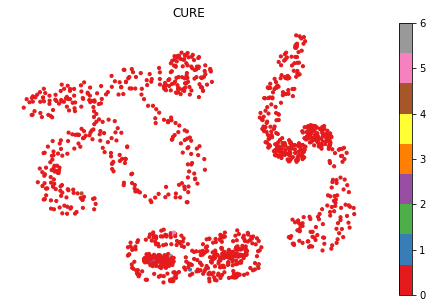

In [51]:
synthetic_data_cure = get_pycluster_result(synthetic_data, cure, False, "CURE")

ARI 0.5368590873785082
Spatial contiguity:  0.5501580914055764
f1_score  0.6353867526903926 [6, 4, 7, 3, 2, 5, 1]


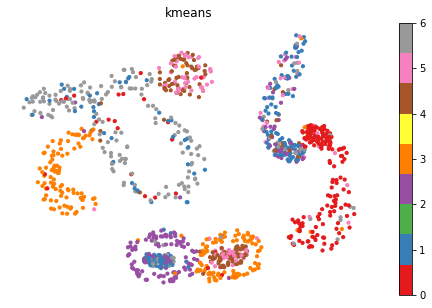

In [52]:
synthetic_data_kmeans = get_pycluster_result(synthetic_data, kmeans, False, "kmeans")

ARI 0.8241512383311884
Spatial contiguity:  0.8766887036504742
f1_score  0.742620245910928 [7, 1, 6, 4, 2, 3, 5]


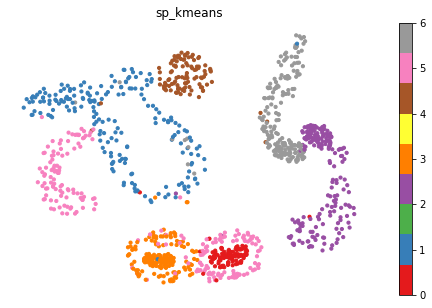

In [35]:
synthetic_data_kmeans = get_pycluster_result(synthetic_data, kmeans, False, "sp_kmeans")

# Density-based

In [36]:
def get_pycluster_result(ground_truth, cluster_method, radius, neighbors, save_fig=False, title="Title"):
    data = ground_truth[["x", "y"]].values
    
    if cluster_method == dbscan:      
        instance = cluster_method(data, radius, neighbors)
    elif cluster_method == cure:
        instance = cluster_method(data, 7)
    else:
        instance = cluster_method(data.tolist(), 7)

    instance.process()
    clusters = instance.get_clusters()
    
    clusters_result = {}
    clusters_result_list = []
    
    for i, clus in enumerate(clusters):
        for data in clus:
            clusters_result[data] = i
    
    for i in range(ground_truth.shape[0]):
        if i in clusters_result.keys():
            clusters_result_list.append([i, clusters_result[i]])
        else:
            clusters_result_list.append([i, -1])
    clusters_result_df = pd.DataFrame(clusters_result_list, columns=["pt", "group"]).sort_values("pt").set_index("pt")
    
    synthetic_data_cluster = ground_truth.join(clusters_result_df)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    markersize = 10
    synthetic_data_cluster.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)
    
    ax.set_axis_off()
    if save_fig:
        ax.title.set_text(f'{title}')
        fig.savefig(f'paper/exp1_result/{title}.jpg', dpi=300, bbox_inches='tight')
    
    print("ARI", adjusted_rand_score(synthetic_data_cluster.group, synthetic_data_cluster.clus_group_gt))
    
    sp_contiguity = cal_joint_statistic(synthetic_data_cluster, w_voronoi)
    print("Spatial contiguity: ", sp_contiguity)

    return synthetic_data_cluster

ARI 0.32731248220334885
Spatial contiguity:  0.9410750215579189


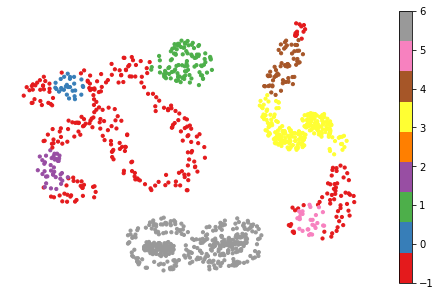

In [37]:
synthetic_data_dbscan = get_pycluster_result(synthetic_data, dbscan, 1250, 25, False, "DBSCAN")

# GMM

In [38]:
gmm_data = synthetic_data.copy()
gmm_data.head(1)

,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [39]:
X = gmm_data[["attr1", "attr2", "attr3", "attr4", "attr5"]].values

In [40]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [41]:
gm = GaussianMixture(n_components=7).fit(X)
gmm = pd.DataFrame(gm.predict(X), columns=["group"])
gmm.head(1)

,group
0,3


ARI 0.59594872333268
Spatial contiguity:  0.6335153779821788
f1_score  0.676367617716395 [5, 3, 2, 1, 4, 7, 6]


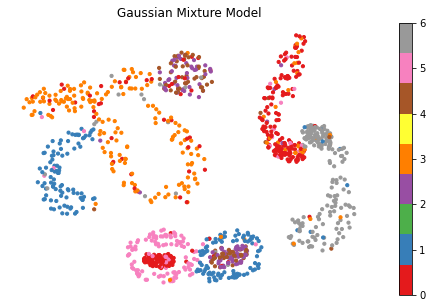

In [42]:
gmm_cluster = gmm_data.join(gmm)

fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
gmm_cluster.plot(column="group", cmap="Set1", markersize=markersize, legend=True, ax=ax)

ax.set_axis_off()
title = "Gaussian Mixture Model"

ax.title.set_text(f'{title}')
print("ARI", adjusted_rand_score(gmm_cluster.group, gmm_cluster.clus_group_gt))

sp_contiguity = cal_joint_statistic(gmm_cluster, w_voronoi)
print("Spatial contiguity: ", sp_contiguity)

get_max_f1_score(gmm_cluster)

# Spatially Constrained Multivariate Clustering using ArcGIS

In [43]:
arcgis_result = gpd.read_file('data/sticc_points_spatial_multivariate.shp')
arcgis_result.head(1)

,SOURCE_ID,synthetic_,syntheti_1,syntheti_2,syntheti_3,syntheti_4,CLUSTER_ID,MEM_PROB,geometry
0,0,4.384146,4.001144,87.435936,853.202725,997.15953,1,0.7,POINT (-9964751.414 5323459.701)


In [44]:
arcgis_result.CLUSTER_ID.unique()

array([1, 2, 5, 3, 4, 6, 7])

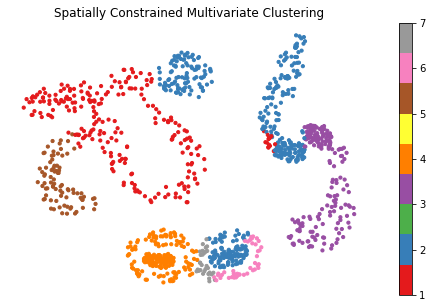

In [45]:
fig, ax = plt.subplots(figsize=(10, 5))
markersize = 10
synthetic_data_sticc_plot = arcgis_result.copy()
synthetic_data_sticc_plot.plot(column="CLUSTER_ID", cmap="Set1", markersize=markersize, legend=True, ax=ax)
ax.set_axis_off()
ax.title.set_text('Spatially Constrained Multivariate Clustering')

In [46]:
arcgis_data = synthetic_data.copy()
arcgis_data = arcgis_data.reset_index()
arcgis_data.head(1)

,index,clus_group,x,y,geometry,clus_group_gt,attr1,attr2,attr3,attr4,attr5,n_pt_0,n_pt_1,n_pt_2
0,0,1,660.0,15060.0,POINT (660.000 15060.000),1,4.471435,2.15853,96.540978,1016.510958,997.32216,41,78,45


In [47]:
arcgis_cluster = pd.merge(left=arcgis_data, left_on=arcgis_data["index"], 
                          right=arcgis_result[["SOURCE_ID", "CLUSTER_ID"]], 
                          right_on=arcgis_result.SOURCE_ID).rename({"CLUSTER_ID": "group"}, axis=1)
print("ARI", adjusted_rand_score(arcgis_cluster.group, arcgis_cluster.clus_group_gt))

sp_contiguity = cal_joint_statistic(arcgis_cluster, w_voronoi)
print("Spatial contiguity: ", sp_contiguity)

get_max_f1_score(arcgis_cluster)

ARI 0.6290249736978822
Spatial contiguity:  0.935901121011785
f1_score  0.5466289937184365 [5, 1, 2, 6, 4, 3, 7]


# MRF Explanation

In [48]:
def compute_centrality(mrf_G):
    for edge in mrf_G.edges:
        origin = edge[0]
        dest = edge[1]
        mrf_G[origin][dest]['weight'] = mrf[origin][dest]
    centrality_dict = nx.algorithms.centrality.betweenness_centrality(mrf_G, weight="weight")
    return centrality_dict

In [53]:
clus = 7
for cluster in range(clus):
    with open(f'output_folder/MRF_synthetic_data_{cluster}.npy', 'rb') as f:
        mrf = np.load(f)
        mrf_G = nx.from_numpy_matrix(mrf)
        between_centrality = compute_centrality(mrf_G)
        print(cluster, between_centrality)

0 {0: 0.7417582417582418, 1: 0.6868131868131868, 2: 0.4560439560439561, 3: 0.18131868131868134, 4: 0.6043956043956045, 5: 0.7527472527472528, 6: 0.14285714285714288, 7: 0.6923076923076924, 8: 0.24725274725274726, 9: 0.20329670329670332, 10: 0.8131868131868133, 11: 0.6758241758241759, 12: 0.2802197802197802, 13: 0.27472527472527475, 14: 0.7032967032967034}
1 {0: 0.8571428571428572, 1: 0.7967032967032968, 2: 0.1043956043956044, 3: 0.23626373626373628, 4: 0.3241758241758242, 5: 0.9120879120879122, 6: 0.6263736263736264, 7: 0.25824175824175827, 8: 0.19780219780219782, 9: 0.36813186813186816, 10: 0.8846153846153847, 11: 0.7087912087912088, 12: 0.2967032967032967, 13: 0.34065934065934067, 14: 0.554945054945055}
2 {0: 0.8241758241758242, 1: 0.42307692307692313, 2: 0.6263736263736264, 3: 0.06593406593406594, 4: 0.7582417582417583, 5: 0.8846153846153847, 6: 0.48901098901098905, 7: 0.34065934065934067, 8: 0.14835164835164835, 9: 0.5879120879120879, 10: 0.8956043956043956, 11: 0.5164835164835165,